/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_65852/3012342793.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x='company_id', y='vader_compound',


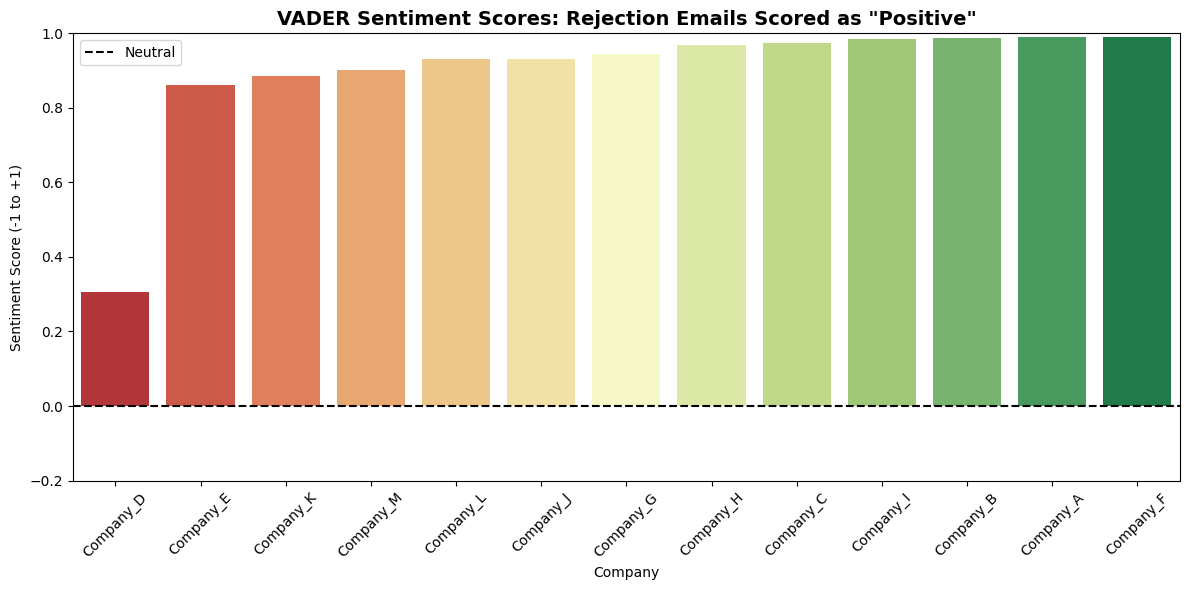

Average sentiment: 0.897
Median sentiment: 0.944
Range: 0.307 to 0.990


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df = pd.read_csv("../data/rejection_analysis.csv")
df_sorted = df[df['status'] != 'ghosted'].sort_values('vader_compound')


plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x='company_id', y='vader_compound', 
            palette='RdYlGn')
plt.axhline(y=0, color='black', linestyle='--', label='Neutral')
plt.title('VADER Sentiment Scores: Rejection Emails Scored as "Positive"', 
          fontsize=14, fontweight='bold')
plt.xlabel('Company')
plt.ylabel('Sentiment Score (-1 to +1)')
plt.xticks(rotation=45)
plt.ylim(-0.2, 1.0)
plt.legend()
plt.tight_layout()
plt.savefig('sentiment_paradox.png', dpi=300)
plt.show()

print(f"Average sentiment: {df_sorted['vader_compound'].mean():.3f}")
print(f"Median sentiment: {df_sorted['vader_compound'].median():.3f}")
print(f"Range: {df_sorted['vader_compound'].min():.3f} to {df_sorted['vader_compound'].max():.3f}")

In [38]:
# Filter out 'ghosted' rows
df_filtered = df[df['status'] != 'ghosted']

# Select only numeric columns
numeric_cols = df_filtered.select_dtypes(include='number')

# Compute correlation
correlation = numeric_cols.corr()

# Show correlations with vader_compound
if 'vader_compound' in correlation.columns:
    print("Correlations with sentiment:")
    print(correlation['vader_compound'].sort_values(ascending=False))
else:
    print("No numeric column named 'vader_compound' found.")


Correlations with sentiment:
vader_compound            1.000000
textblob_polarity         0.729329
personal_pronouns         0.456164
word_count                0.423169
email_length              0.418763
sentence_count            0.358974
empathy_words             0.190150
flesch_reading           -0.117955
apology_words            -0.390083
days_since_application         NaN
Name: vader_compound, dtype: float64


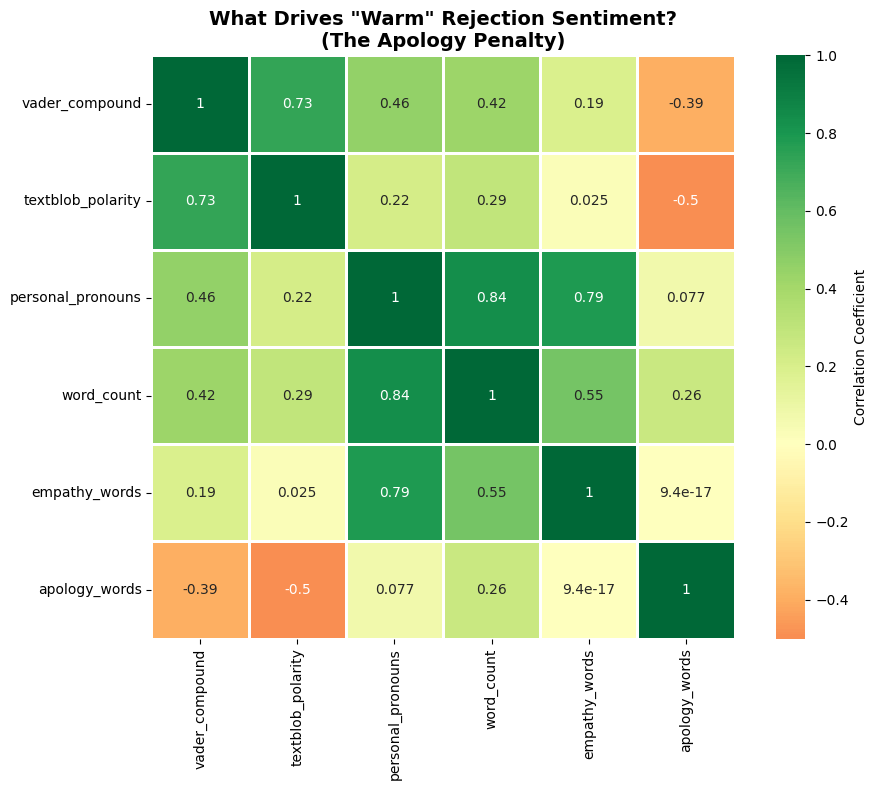

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Correlation heatmap focusing on key insights
correlations = df[df['status'] != 'ghosted'][[
    'vader_compound', 'textblob_polarity', 'personal_pronouns',
    'word_count', 'empathy_words', 'apology_words'
]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='RdYlGn', center=0, 
            vmin=-0.5, vmax=1, square=True, linewidths=1,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('What Drives "Warm" Rejection Sentiment?\n(The Apology Penalty)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()

🚨 Major Discoveries in This Heatmap:

### 1. TextBlob is HARSHER on Apologies than VADER
Apology words correlation:
- VADER:   -0.39 (orange)
- TextBlob: -0.5 (darker orange) 

**Both sentiment models agree:** Apologizing lowers sentiment, but TextBlob punishes it even more.

---

### **2. Empathy Words Actually HURT TextBlob Score**
```
Empathy words → TextBlob polarity: 0.025 (weak positive)
Empathy words → VADER compound: +0.19 (weak positive)
```

TextBlob and VADER sees Empathy words as slightly (little!) positive and they don't matter much.

**What this means:**  "Thank you" and "appreciate" are noise to algorithms.

---

### **3. Personal Pronouns ↔ Word Count (0.84) 🤯**
```
Strongest correlation in the entire dataset!
```

**What this means:** Longer emails naturally contain more "you/your" references. You can't separate personalization from length.

**Implication:** Companies that write longer rejections automatically sound more personal, even if the content is generic.

---

### **4. The Empathy Paradox Visualized**
```
Empathy words correlate with:
- Personal pronouns: +0.79 ✅
- Word count: +0.55 ✅
- Sentiment scores: +0.19 / 0.025 🤷
```
**What this means:** Empathy words appear in longer, more personal emails, but don't independently drive sentiment.

---

### **5. Cross-Model Agreement on The Apology Penalty**
```
           VADER    TextBlob
Apology:   -0.39    -0.5    ← Both negative 
Personal:  +0.46    +0.22    ← Both positive
Empathy:   +0.15    0.025   ← Both positive
```

**The models only strongly agree on two things:**
1. Apologies = bad
2. Personal pronouns = good


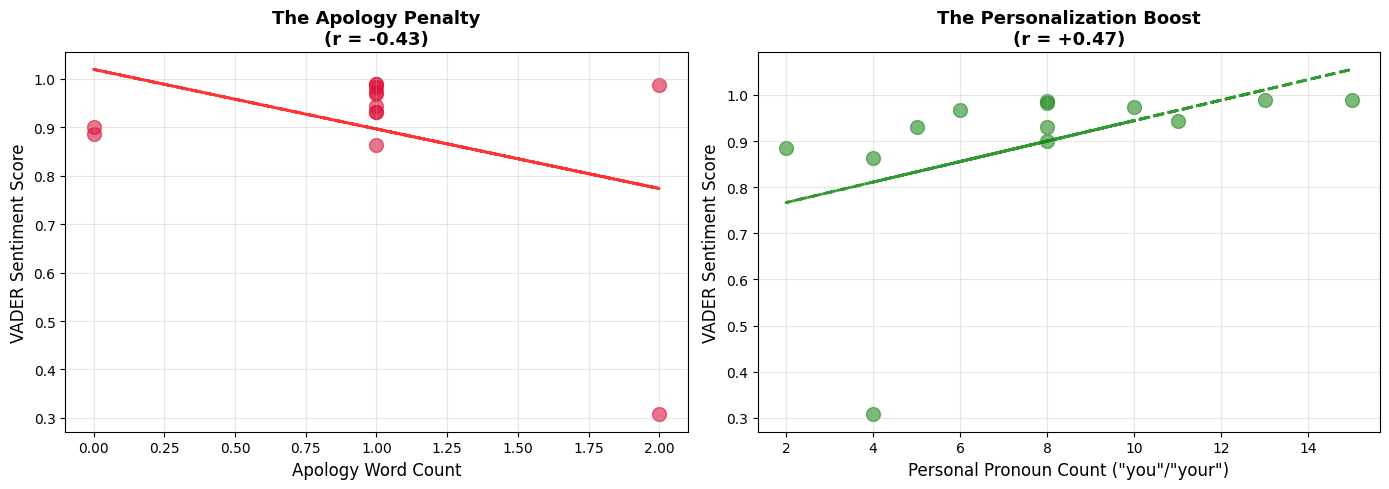


📊 Key Finding:
Emails with 3+ apology words: avg sentiment = nan
Emails with 0-1 apology words: avg sentiment = 0.942


In [40]:
# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

df_plot = df[df['status'] != 'ghosted']

# Left: Apology words (NEGATIVE correlation)
ax1.scatter(df_plot['apology_words'], df_plot['vader_compound'], 
            s=100, alpha=0.6, c='crimson')
z1 = np.polyfit(df_plot['apology_words'], df_plot['vader_compound'], 1)
p1 = np.poly1d(z1)
ax1.plot(df_plot['apology_words'], p1(df_plot['apology_words']), 
         "r--", alpha=0.8, linewidth=2)
ax1.set_xlabel('Apology Word Count', fontsize=12)
ax1.set_ylabel('VADER Sentiment Score', fontsize=12)
ax1.set_title('The Apology Penalty\n(r = -0.43)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Right: Personal pronouns (POSITIVE correlation)
ax2.scatter(df_plot['personal_pronouns'], df_plot['vader_compound'],
            s=100, alpha=0.6, c='forestgreen')
z2 = np.polyfit(df_plot['personal_pronouns'], df_plot['vader_compound'], 1)
p2 = np.poly1d(z2)
ax2.plot(df_plot['personal_pronouns'], p2(df_plot['personal_pronouns']),
         "g--", alpha=0.8, linewidth=2)
ax2.set_xlabel('Personal Pronoun Count ("you"/"your")', fontsize=12)
ax2.set_ylabel('VADER Sentiment Score', fontsize=12)
ax2.set_title('The Personalization Boost\n(r = +0.47)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('apology_vs_personalization.png', dpi=300)
plt.show()

print("\n📊 Key Finding:")
print(f"Emails with 3+ apology words: avg sentiment = {df_plot[df_plot['apology_words'] >= 3]['vader_compound'].mean():.3f}")
print(f"Emails with 0-1 apology words: avg sentiment = {df_plot[df_plot['apology_words'] <= 1]['vader_compound'].mean():.3f}")


📊 Sentiment by Apology Level:
                 vader_compound      
                           mean count
apology_category                     
No Apology                0.893     2
Standard (1-2)            0.897    11


/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_65852/1116427362.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['apology_category'] = df_plot['apology_words'].apply(categorize_apology)
/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_65852/1116427362.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='apology_category', y='vader_compound',


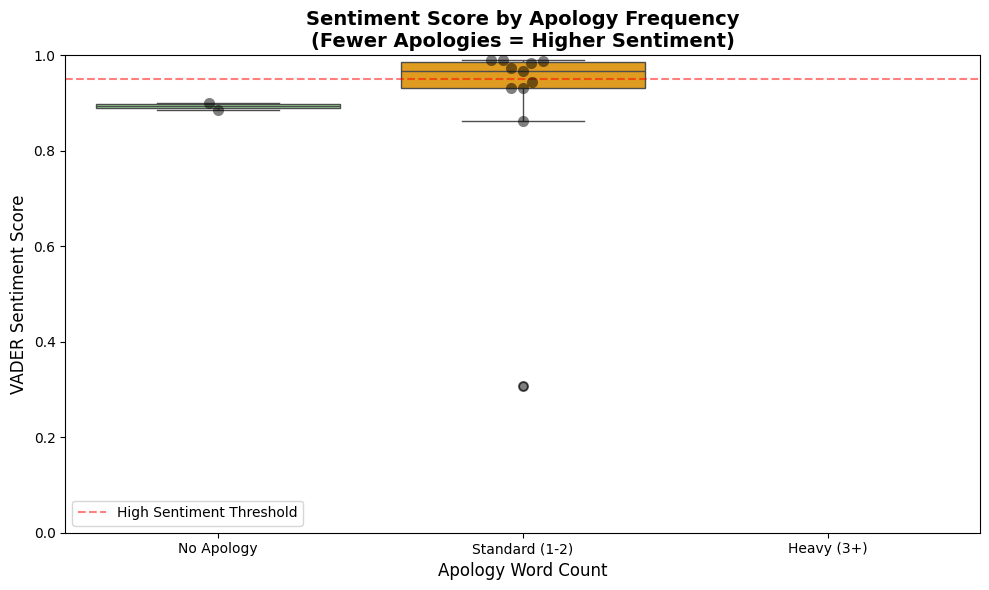

In [41]:
# Create apology categories based on actual distribution
def categorize_apology(count):
    if count == 0:
        return 'No Apology'
    elif count <= 2:
        return 'Standard (1-2)'
    else:
        return 'Heavy (3+)'

df_plot['apology_category'] = df_plot['apology_words'].apply(categorize_apology)

# Compare sentiment across categories
apology_comparison = df_plot.groupby('apology_category').agg({
    'vader_compound': ['mean', 'count']
}).round(3)

print("\n📊 Sentiment by Apology Level:")
print(apology_comparison)

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x='apology_category', y='vader_compound',
            order=['No Apology', 'Standard (1-2)', 'Heavy (3+)'],
            palette=['lightgreen', 'orange', 'lightcoral'])
sns.swarmplot(data=df_plot, x='apology_category', y='vader_compound',
              order=['No Apology', 'Standard (1-2)', 'Heavy (3+)'],
              color='black', alpha=0.5, size=8)

plt.title('Sentiment Score by Apology Frequency\n(Fewer Apologies = Higher Sentiment)', 
          fontsize=14, fontweight='bold')
plt.ylabel('VADER Sentiment Score', fontsize=12)
plt.xlabel('Apology Word Count', fontsize=12)
plt.ylim(0, 1.0)
plt.axhline(y=0.95, color='red', linestyle='--', alpha=0.5, label='High Sentiment Threshold')
plt.legend()
plt.tight_layout()
plt.savefig('apology_levels.png', dpi=300)
plt.show()

In [47]:
# Find the no-apology emails
no_apology_companies = df_plot[df_plot['apology_words'] == 0]

print("\n🟢 THE 'NO APOLOGY' EMAILS:\n")
for idx, row in no_apology_companies.iterrows():
    print(f"{row['company_id']}")
    print(f"  Sentiment: {row['vader_compound']:.3f}")
    print(f"  Length: {row['word_count']} words")
    print(f"  Empathy words: {row['empathy_words']}")
    print(f"  Personal pronouns: {row['personal_pronouns']}")
    print(f"  Preview: {row['email_text'][:150]}...")
    print()


🟢 THE 'NO APOLOGY' EMAILS:

Company_K
  Sentiment: 0.886
  Length: 45 words
  Empathy words: 1
  Personal pronouns: 2
  Preview: Hi [Name], Thank you for your interest in our vacancy. However, all the spots of this vacancy are already filled, so we're not looking for new candida...

Company_M
  Sentiment: 0.901
  Length: 84 words
  Empathy words: 2
  Personal pronouns: 8
  Preview: Dear [Candidate], thank you for your application. We are providing some feedback as part of our learning-focused process. After reviewing your CV and ...



/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_65852/259958539.py:36: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_65852/259958539.py:36: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_65852/259958539.py:37: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('apology_vs_personalization_final.png', dpi=300, bbox_inches='tight')
/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_65852/259958539.py:37: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('apology_vs_personalization_final.png', dpi=300, bbox_inches='tight')
/Users/chotij/Documents/Coding/job_rejection_analysis/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyp

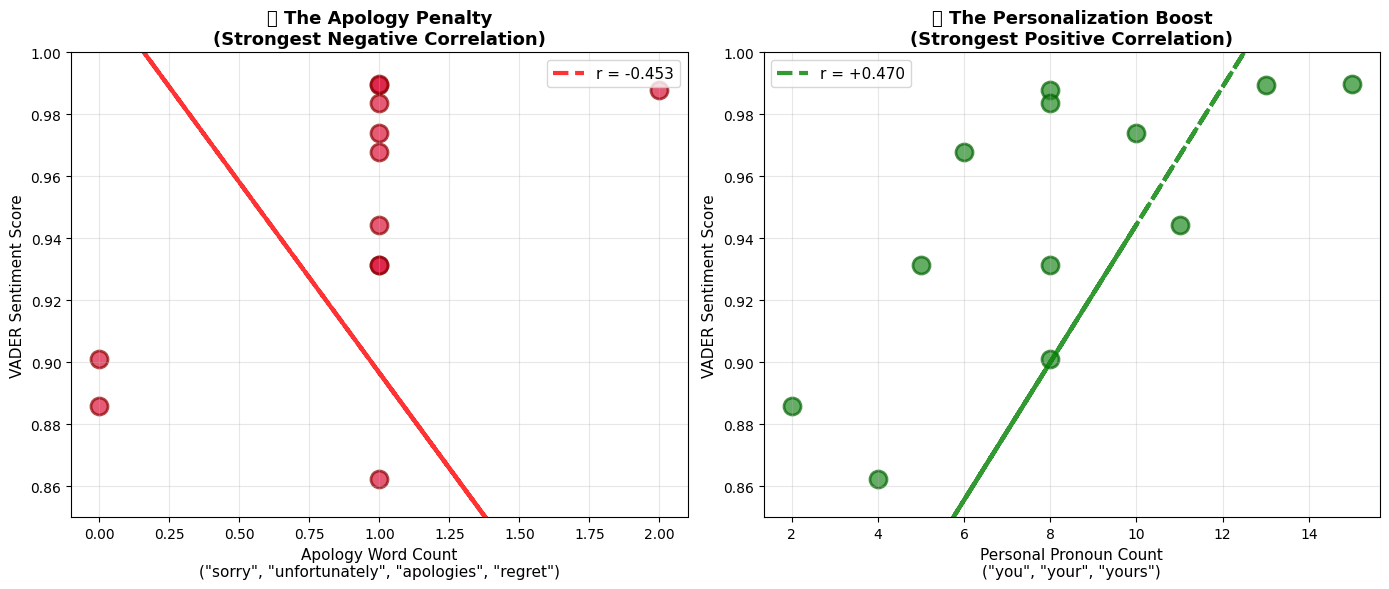


💡 The Formula for High-Sentiment Rejection:
✅ Use personal pronouns (+0.47 correlation)
✅ Write longer emails (+0.43 correlation)
❌ Avoid apology words (-0.45 correlation)
= Warm-sounding rejection without acknowledging disappointment


In [48]:
# Direct comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

df_plot = df[df['status'] != 'ghosted']

# Left: Apology words (NEGATIVE -0.453)
ax1.scatter(df_plot['apology_words'], df_plot['vader_compound'], 
            s=150, alpha=0.7, c='crimson', edgecolors='darkred', linewidth=2)
z1 = np.polyfit(df_plot['apology_words'], df_plot['vader_compound'], 1)
p1 = np.poly1d(z1)
ax1.plot(df_plot['apology_words'], p1(df_plot['apology_words']), 
         "r--", alpha=0.8, linewidth=3, label=f'r = -0.453')
ax1.set_xlabel('Apology Word Count\n("sorry", "unfortunately", "apologies", "regret")', fontsize=11)
ax1.set_ylabel('VADER Sentiment Score', fontsize=11)
ax1.set_title('❌ The Apology Penalty\n(Strongest Negative Correlation)', 
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_ylim(0.85, 1.0)

# Right: Personal pronouns (POSITIVE +0.470)
ax2.scatter(df_plot['personal_pronouns'], df_plot['vader_compound'],
            s=150, alpha=0.7, c='forestgreen', edgecolors='darkgreen', linewidth=2)
z2 = np.polyfit(df_plot['personal_pronouns'], df_plot['vader_compound'], 1)
p2 = np.poly1d(z2)
ax2.plot(df_plot['personal_pronouns'], p2(df_plot['personal_pronouns']),
         "g--", alpha=0.8, linewidth=3, label=f'r = +0.470')
ax2.set_xlabel('Personal Pronoun Count\n("you", "your", "yours")', fontsize=11)
ax2.set_ylabel('VADER Sentiment Score', fontsize=11)
ax2.set_title('✅ The Personalization Boost\n(Strongest Positive Correlation)',
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.set_ylim(0.85, 1.0)

plt.tight_layout()
plt.savefig('apology_vs_personalization_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 The Formula for High-Sentiment Rejection:")
print("✅ Use personal pronouns (+0.47 correlation)")
print("✅ Write longer emails (+0.43 correlation)")
print("❌ Avoid apology words (-0.45 correlation)")
print("= Warm-sounding rejection without acknowledging disappointment")

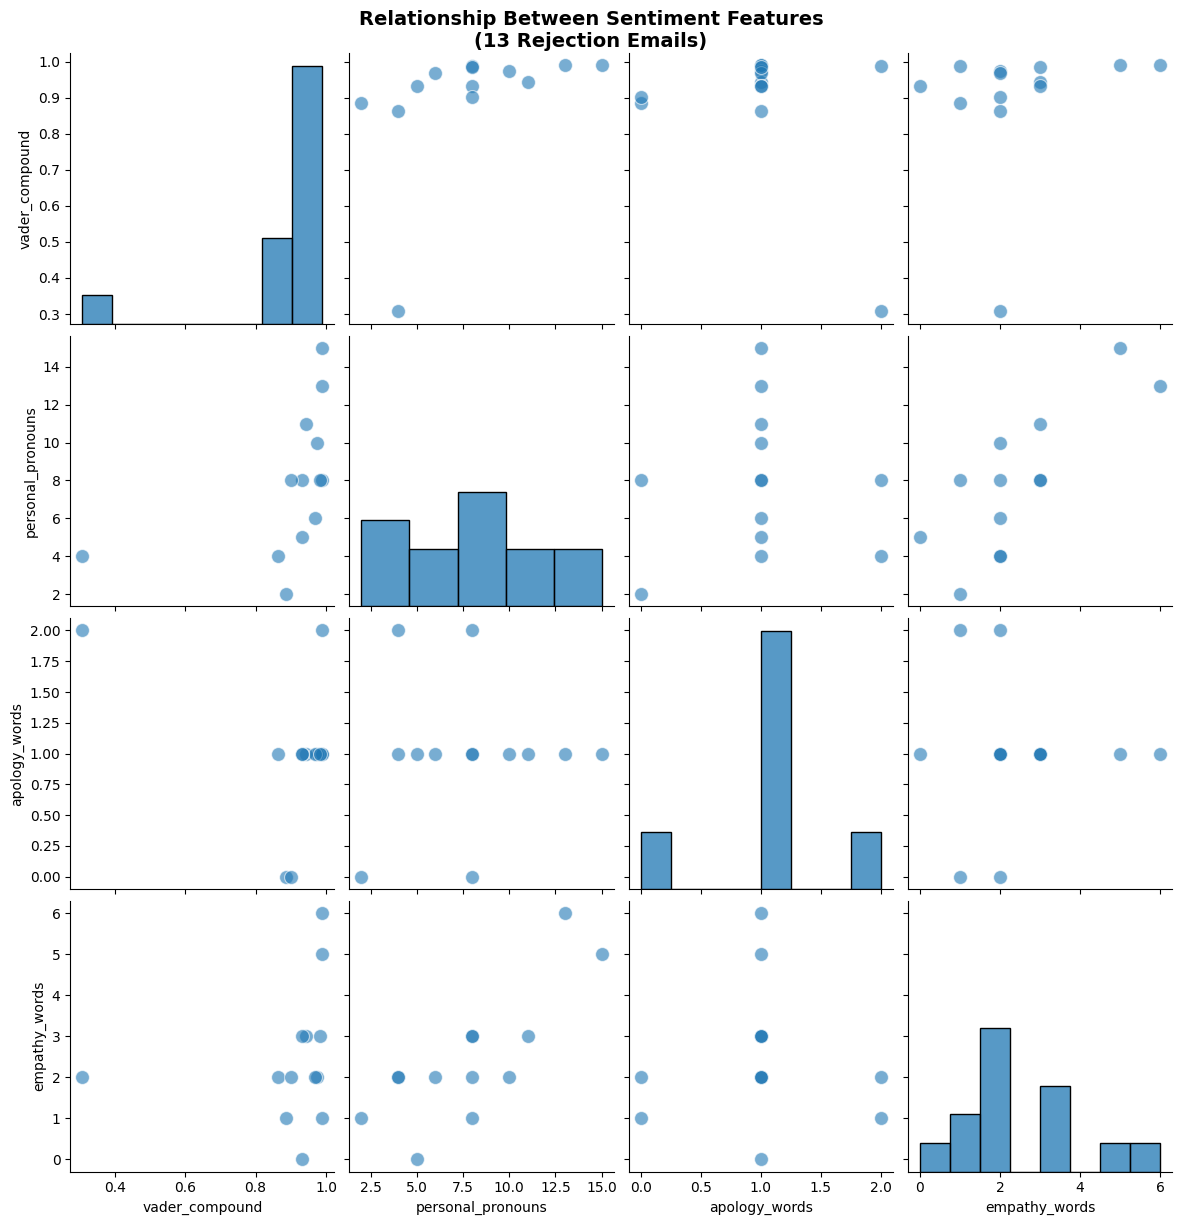

In [44]:
import seaborn as sns

# Select key variables
plot_vars = ['vader_compound', 'personal_pronouns', 'apology_words', 'empathy_words']
plot_df = df[df['status'] != 'ghosted'][plot_vars]

# Create pairplot
g = sns.pairplot(plot_df, diag_kind='hist', plot_kws={'alpha': 0.6, 's': 100},
                 height=3, aspect=1)
g.fig.suptitle('Relationship Between Sentiment Features\n(13 Rejection Emails)', 
               fontsize=14, fontweight='bold', y=1.02)
plt.savefig('pairplot_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

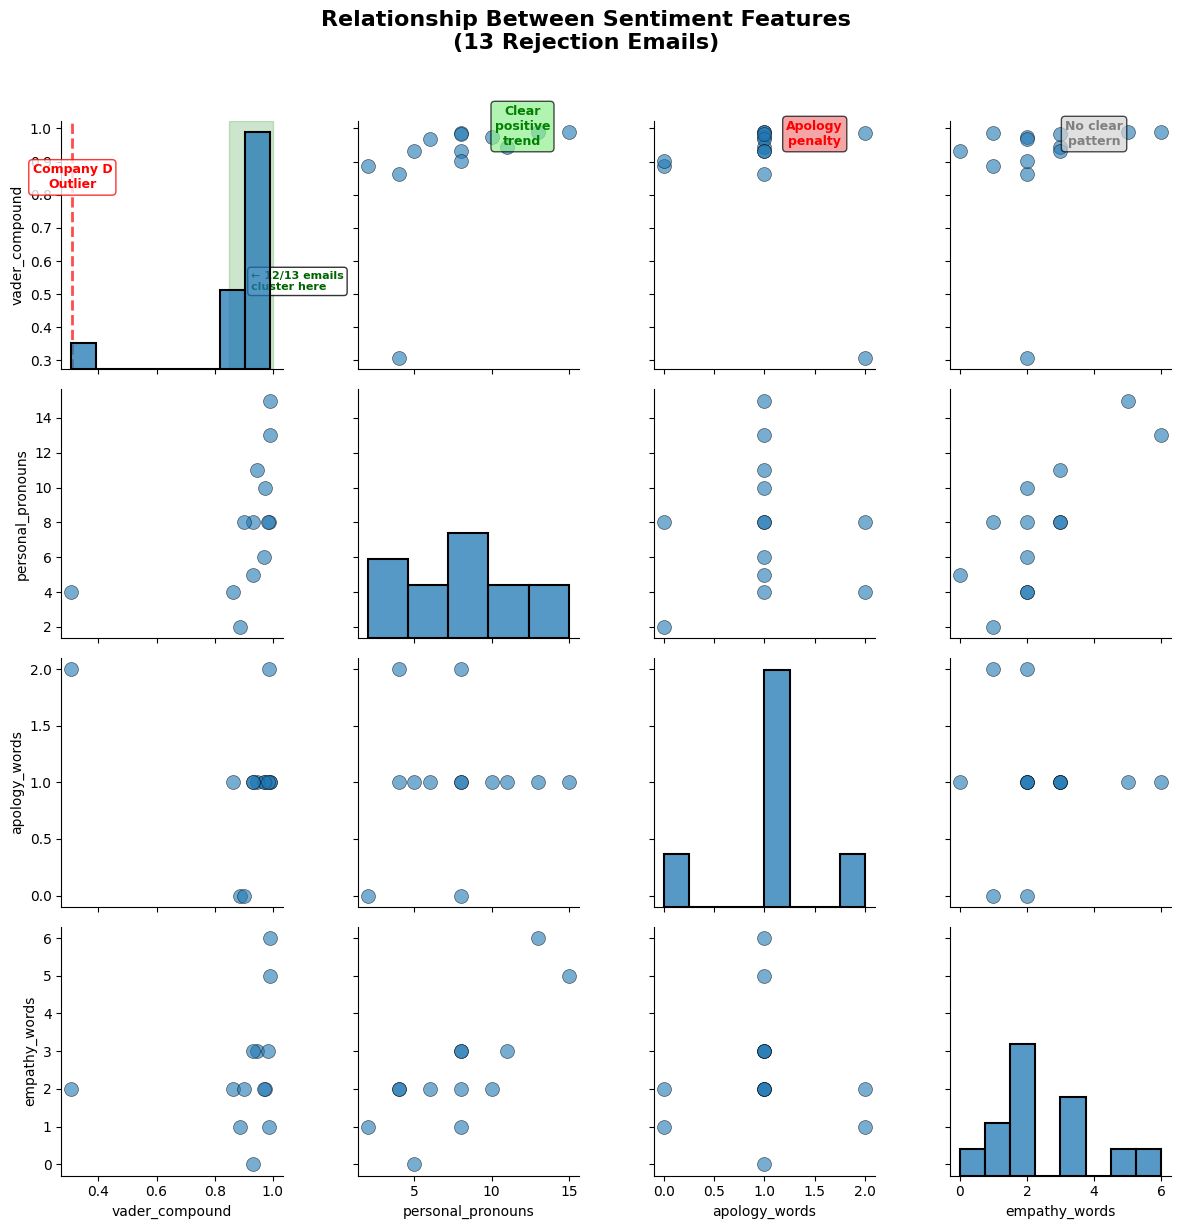

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Create the pairplot
plot_vars = ['vader_compound', 'personal_pronouns', 'apology_words', 'empathy_words']
plot_df = df[df['status'] != 'ghosted'][plot_vars]

g = sns.pairplot(plot_df, diag_kind='hist', 
                 plot_kws={'alpha': 0.6, 's': 100, 'edgecolor': 'black', 'linewidth': 0.5},
                 diag_kws={'edgecolor': 'black', 'linewidth': 1.5},
                 height=3, aspect=1, corner=False)

# Add title
g.fig.suptitle('Relationship Between Sentiment Features\n(13 Rejection Emails)', 
               fontsize=16, fontweight='bold', y=1.02)

# Annotate key findings
# 1. Highlight the outlier in VADER distribution
axes = g.axes
axes[0, 0].axvline(x=0.31, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[0, 0].text(0.31, axes[0, 0].get_ylim()[1] * 0.8, 'Company D\nOutlier', 
                fontsize=9, color='red', fontweight='bold', ha='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='red', alpha=0.8))

# 2. Annotate the positive trend (VADER vs pronouns)
axes[0, 1].text(12, 0.95, 'Clear\npositive\ntrend', fontsize=9, color='green',
                fontweight='bold', ha='center',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# 3. Annotate the negative trend (VADER vs apologies)
axes[0, 2].text(1.5, 0.95, 'Apology\npenalty', fontsize=9, color='red',
                fontweight='bold', ha='center',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

# 4. Annotate the scatter (VADER vs empathy)
axes[0, 3].text(4, 0.95, 'No clear\npattern', fontsize=9, color='gray',
                fontweight='bold', ha='center',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))

# 5. Highlight the distribution cluster
axes[0, 0].axvspan(0.85, 1.0, alpha=0.2, color='green')
axes[0, 0].text(0.925, axes[0, 0].get_ylim()[1] * 0.5, '← 12/13 emails\ncluster here', 
                fontsize=8, color='darkgreen', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('pairplot_annotated.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
# New top 5 and bottom 3
top_companies = df[df['status'] != 'ghosted'].nlargest(5, 'vader_compound')
bottom_companies = df[df['status'] != 'ghosted'].nsmallest(3, 'vader_compound')

print("TOP 5 HIGHEST SENTIMENT:")
print(top_companies[['company_id', 'vader_compound', 'email_length', 'personal_pronouns', 'apology_words']])

print("\nBOTTOM 3 LOWEST SENTIMENT:")
print(bottom_companies[['company_id', 'vader_compound', 'email_length', 'personal_pronouns', 'apology_words']])

TOP 5 HIGHEST SENTIMENT:
  company_id  vader_compound  email_length  personal_pronouns  apology_words
5  Company_F          0.9898           945                 15              1
0  Company_A          0.9894          1023                 13              1
1  Company_B          0.9878           834                  8              2
8  Company_I          0.9836           786                  8              1
2  Company_C          0.9739           897                 10              1

BOTTOM 3 LOWEST SENTIMENT:
   company_id  vader_compound  email_length  personal_pronouns  apology_words
3   Company_D          0.3071           422                  4              2
4   Company_E          0.8625           222                  4              1
10  Company_K          0.8860           265                  2              0
